# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras import layers, Model, Sequential, callbacks, losses, optimizers, datasets

# Vars

In [3]:
LATENT_DIM = int(10e2)
BATCH_SIZE = 2**14
EPOCHS = 100

# Data Loading

In [ ]:
(x_train, _), (_, _) = datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = (x_train - 0.5) * 2
# x_train = np.expand_dims(x_train, axis=-1)
x_train = x_train.reshape(-1, 784)

dataset = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [5]:
x_train.shape

(60000, 784)

# Generator

In [6]:
class Generator(Model):
    """
    Генератор Keras. Принимает тензор размерности (batch_size, 100)
    и возвращает тензор размерности (batch_size, 784).
    Цель - генерировать изображения, неотличимые от настоящих цифр MNIST
    """

    def __init__(self):
        super(Generator, self).__init__()

        # Последовательность слоев
        self.dense_blocks = Sequential(
            [
                layers.Dense(256),
                layers.LeakyReLU(negative_slope=0.01),
                layers.Dense(512),
                layers.LeakyReLU(negative_slope=0.01),
                layers.Dense(1024),
                layers.LeakyReLU(negative_slope=0.01),
                layers.Dense(28 * 28, activation="tanh"),
            ]
        )

    def call(self, inputs):
        return self.dense_blocks(inputs)

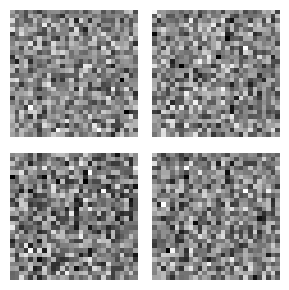

In [7]:
def plot_generated_images(generator, num_images=16, noise_dim=100):
    """
    Генерация и отрисовка изображений с помощью генератора

    Аргументы:
    generator -- модель генератора
    num_images -- количество изображений для отрисовки (должно быть квадратом целого числа)
    noise_dim -- размерность входного шума
    """
    # Генерация случайного шума
    noise = tf.random.normal([num_images, noise_dim])

    # Генерация изображений
    generated_images = generator(noise).numpy()

    # Масштабирование из [-1, 1] в [0, 1]
    generated_images = (generated_images + 1) / 2

    # Настройка сетки для отображения
    rows = int(np.sqrt(num_images))
    cols = rows
    fig, axes = plt.subplots(rows, cols, figsize=(3, 3))

    # Отрисовка изображений
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Создание экземпляра генератора
generator = Generator()

plot_generated_images(generator, 2 ** (max(3, 2)))

# Discriminator

In [8]:
class Discriminator(Model):
    """
    Дискриминатор Keras. Принимает тензор размерности (batch_size, 784)
    и возвращает тензор размерности (batch_size, 1) с вероятностями принадлежности
    к реальным данным
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        self.dense_blocks = Sequential(
            [
                layers.Dense(1024),
                layers.LeakyReLU(negative_slope=0.01),
                layers.Dense(512),
                layers.LeakyReLU(negative_slope=0.01),
                layers.Dense(256),
                layers.LeakyReLU(negative_slope=0.01),
                layers.Dense(1, activation="sigmoid"),
            ]
        )

    def call(self, inputs):
        return self.dense_blocks(inputs)

In [ ]:
discriminator = Discriminator()

real_images = x_train[:16]
real_decisions = discriminator(real_images)

noise = tf.random.normal([16, LATENT_DIM])
fake_images = generator(noise).numpy()
fake_decisions = discriminator(fake_images)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 100, but received input with shape (16, 1000)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(16, 1000), dtype=float32)
  • training=None
  • mask=None

In [11]:
fake_decisions

NameError: name 'fake_decisions' is not defined

# GAN

In [12]:
class GANMonitor(callbacks.Callback):
    def __init__(self, gan_model, test_noise):
        super().__init__()
        self.gan = gan_model
        self.test_noise = test_noise
        self.test_progression = []

    def on_epoch_end(self, epoch, logs=None):
        # Генерация и сохранение изображений
        generated_images = self.gan.generator(self.test_noise)
        self.test_progression.append(generated_images.numpy())

In [13]:
class GAN(Model):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        
        # Фиксированный шум для генерации примеров
        self.test_noises = tf.random.normal((100, 100))

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Обучение дискриминатора
        noise = tf.random.normal((batch_size, 100))
        with tf.GradientTape() as d_tape:
            # Реальные изображения
            pred_real = self.discriminator(real_images)
            # Сгенерированные изображения
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images)
            
            # Потери дискриминатора
            real_loss = self.loss_fn(tf.ones_like(pred_real), pred_real)
            fake_loss = self.loss_fn(tf.zeros_like(pred_fake), pred_fake)
            d_loss = (real_loss + fake_loss) * 0.5
        
        # Обновление весов дискриминатора
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

        # Обучение генератора
        noise = tf.random.normal((batch_size, 100))
        with tf.GradientTape() as g_tape:
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images)
            g_loss = self.loss_fn(tf.ones_like(pred_fake), pred_fake)
        
        # Обновление весов генератора
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [14]:
gan = GAN()
monitor = GANMonitor(gan, gan.test_noises)

# Компиляция с оптимизаторами и функцией потерь
gan.compile(
    g_optimizer=optimizers.Adam(learning_rate=0.0002),
    d_optimizer=optimizers.Adam(learning_rate=0.0002),
    loss_fn=losses.BinaryCrossentropy(),
)


In [ ]:
history = gan.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[monitor],  # Для сохранения изображений через on_epoch_end
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - d_loss: 0.4928 - g_loss: 0.6638
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.4813 - g_loss: 0.6213
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.4184 - g_loss: 0.8158
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.2539 - g_loss: 1.4250
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.1449 - g_loss: 2.1575
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.1115 - g_loss: 2.4352
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.1015 - g_loss: 2.8086
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.0973 - g_loss: 2.9369
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.0861 - g_loss: 3.0848
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.0764 - g_loss: 3.2405
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.0663 - g_loss: 3.3647
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - d_loss: 0.0518 - g_loss: 3.6081
Epoch 13/100


# Test

In [ ]:
def plot_results(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
plot_results(history, "GAN")

Epoch 0


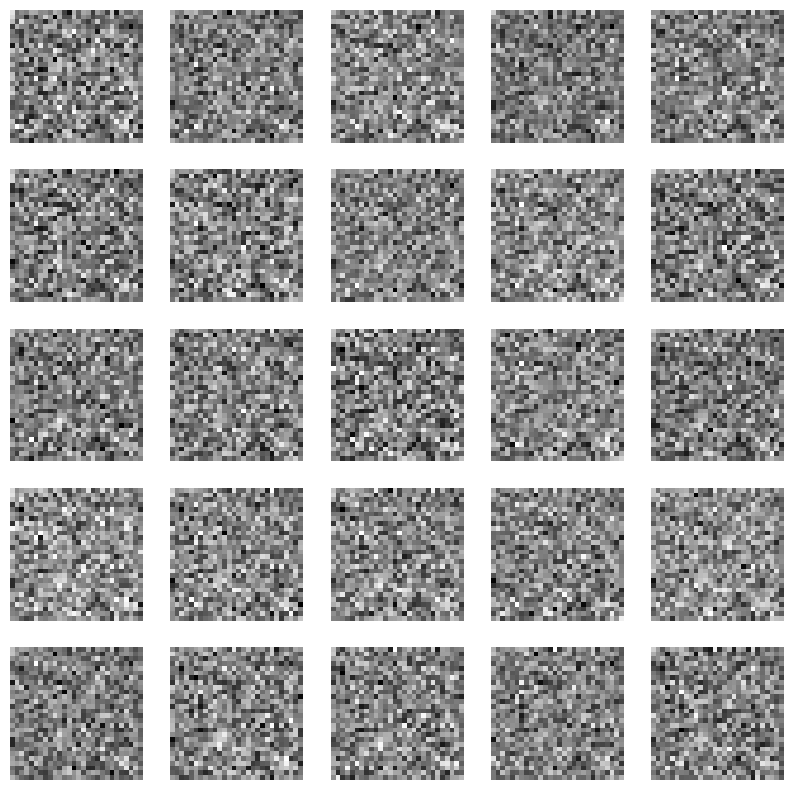

Epoch 5


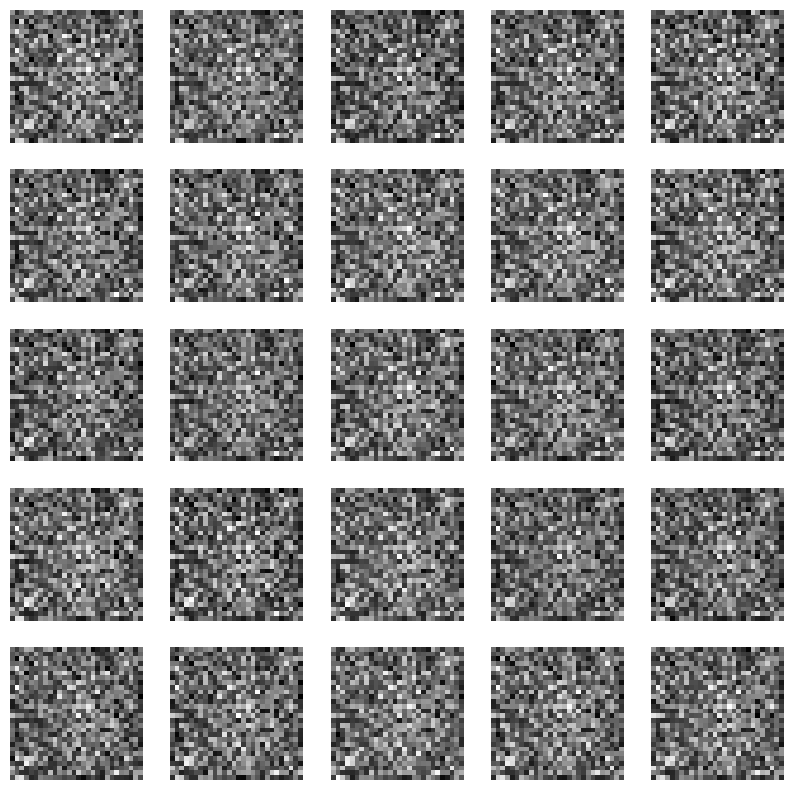

In [ ]:
def plot_images(images):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].reshape(28, 28) * 0.5 + 0.5, cmap='gray')  # Денормализация
        plt.axis('off')
    plt.show()

# Показываем прогрессию из callback'а
for epoch, epoch_images in enumerate(monitor.test_progression):
    if epoch % 5 == 0:  # Каждые 5 эпох
        print(f"Epoch {epoch}")
        plot_images(epoch_images)